# ARCH and GARCH Modeling

## Introduction

ARCH modeling, often referred to as ARCH (Autoregressive Conditional Heteroskedasticity) modeling, is a statistical technique used to model time series data with time-varying volatility. It is particularly useful in financial econometrics for modeling and forecasting the volatility of asset returns.

## Key Concepts

1. **Heteroskedasticity**: This refers to the condition where the variance of the error terms in a regression model is not constant over time.
2. **Autoregressive**: This indicates that the model uses past values of the variable to predict future values.

## ARCH Model

The ARCH model was introduced by Robert Engle in 1982. The basic idea is to model the variance of the current error term as a function of the squared error terms from previous periods.

### Basic ARCH Model

The basic ARCH(q) model can be described as follows:

1. **Mean Equation**:
   
   $y_t = \mu + \epsilon_t$
   
   where $y_t$ is the time series value at time $t$ , $\mu$ is the mean, and $\epsilon_t$ is the error term (return residuals, with respect to a mean process)

2. **Variance Equation**:
   
   $\epsilon_t = \sigma_t z_t$

   $\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \ldots + \alpha_q \epsilon_{t-q}^2 = \alpha_0 +  \sum_{i=1}^q  \alpha_i \epsilon_{t-i}^2$
   
   where  $\sigma_t^2$ is the conditional variance at time $t$, $\alpha_0,\alpha_1 \ldots \alpha_q$ are parameters to be estimated, and $z_t$ is a white noise error term.

## GARCH Model

The Generalized ARCH (GARCH) model extends the ARCH model by including lagged values of the conditional variance. The GARCH(p, q) model can be described as:

1. **Mean Equation**:

   $y_t = \mu + \epsilon_t$

2. **Variance Equation**:

   $\epsilon_t = \sigma_t z_t$
   
   $\sigma_t^2 = \alpha_0 + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2$

   where $\beta_j$ are additional parameters to be estimated.

## Applications

- **Financial Markets**: Modeling and forecasting the volatility of stock returns, exchange rates, and other financial assets.
- **Risk Management**: Estimating Value at Risk (VaR) and other risk metrics.
- **Econometrics**: Analyzing economic time series data with changing volatility.

## Implementation

ARCH and GARCH models can be implemented using various statistical software packages, such as R, Python (with libraries like `arch` and `statsmodels`), and others.

{'init mu': -0.4761812095238096, 'init alpha0': 2.2024427545202676, 'init alpha1': 0, 'init max_log_likelihood': -38.088163614506726}
{'mu': -0.8258359001681276, 'alpha0': 3.1975585748507482, 'alpha1': -0.24816866228120854, 'max_log_likelihood': -20.868403793642194}
[3.19755857e+00 2.87475934e+00 2.97520780e+00 2.60032913e+00
 1.85627710e+00 2.25302926e+00 2.86437123e+00 3.17742099e+00
 2.59433124e+00 2.95143130e+00 2.66193701e+00 3.08844332e+00
 2.94311506e+00 3.12706881e+00 2.77969810e+00 3.14909187e+00
 3.18514949e+00 1.61323249e+00 1.99338878e+00 3.14761168e+00
 4.44089210e-16]


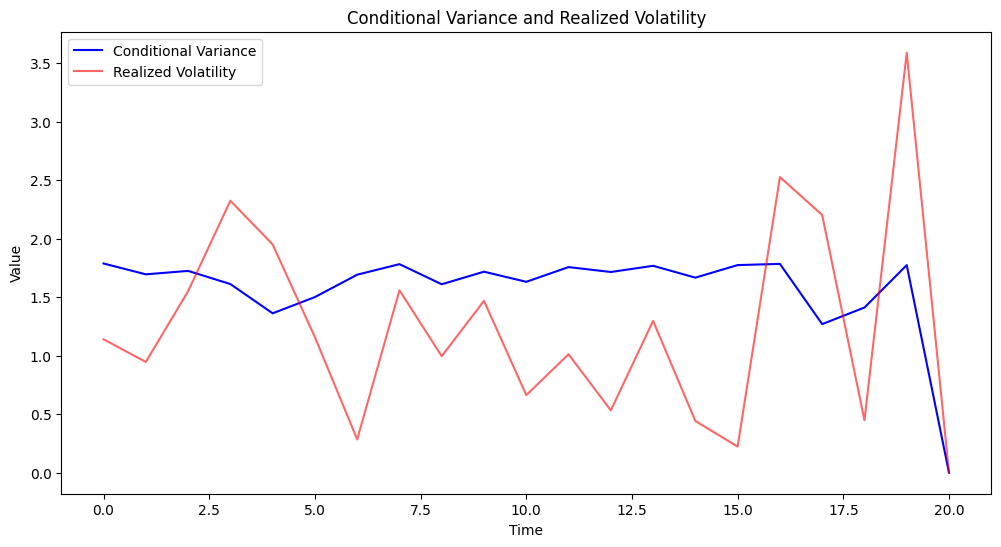

In [16]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class ARCHModel:
    def __init__(self, returns):
        self.returns = np.array(returns) *100
        self.conditionnal_variance = None
        self.mu = None
        self.alpha0 = None
        self.alpha1 = None
        self.max_log_likelihood = None
       
    
    def _compute_residuals(self, mu):
        residuals = self.returns - mu
        shift_residuals = np.roll(residuals, 1)
        shift_residuals[0] = 0
        return residuals, shift_residuals 
    
    def _compute_conditional_variance(self, alpha0, alpha1, shift_residuals):
        variances = alpha0 + alpha1 * shift_residuals ** 2
        return variances
    
    def _log_normal_density(self, residual , variance, error):
        if( np.any(variance <= 0) ):
            #print("variance <=0")
            error[0] = True
            return 0
        else:
            error[0] = False
            return -0.5 * np.log(2 * np.pi * variance) - (residual ** 2) / (2 * variance)    

    def _mle_arch(self, params):
        mu, alpha0, alpha1 = params
        residuals, shift_residuals = self._compute_residuals(mu)
        conditionnal_variance = self._compute_conditional_variance(alpha0, alpha1, shift_residuals)
        error = [False]
        log_likelihood = self._log_normal_density(residuals, conditionnal_variance, error)
        if error[0]:
            #print(f"error : {mu} {alpha0}, {alpha1}")
            return np.inf
        else:
            return -np.sum(log_likelihood)
    
    def fit(self):
        mu = np.mean( self.returns);
        alpha0 =  np.var(self.returns);
        alpha1 = 0  
        
        initial_params = [mu, alpha0, alpha1]
        self.max_log_likelihood = -self._mle_arch(initial_params)

        print( {
            "init mu": mu,
            "init alpha0": alpha0,
            "init alpha1": alpha1,
            "init max_log_likelihood": self.max_log_likelihood
        })

        bounds = [(None, None), (None, None), (None, None)] 
        
        # Minimize the negative log-likelihood
        result = minimize(self._mle_arch, initial_params, bounds=bounds,  method='Nelder-Mead')  #Nelder-Mead SLSQP
        if result.success:
            self.mu, self.alpha0, self.alpha1 = result.x
            self.max_log_likelihood = -result.fun  # Store the maximum log-likelihood
            residuals, shift_residuals = self._compute_residuals(self.mu)
            conditionnal_variance = self._compute_conditional_variance(self.alpha0, self.alpha1,shift_residuals )

            self.mu, self.alpha0, self.alpha1 = result.x
            self.max_log_likelihood = -result.fun  # Store the maximum log-likelihood
            
            return conditionnal_variance

        else:
            raise ValueError("Optimization failed: " + result.message)

       

    def summary(self):
        return {
            "mu": self.mu,
            "alpha0": self.alpha0,
            "alpha1": self.alpha1,
            "max_log_likelihood": self.max_log_likelihood
        }


# Set the seed for reproducibility
np.random.seed(42)

# Generate synthetic data
returns = [0.003146575,-0.017723909,0.007254689,0.014989689,
0.011250607,0.003328635,-0.005409767,0.007332392,0.001700427,
0.006432783,-0.001627508,0.001867275,-0.002928821,0.004717681,
-0.003839112,-0.010494486,-0.033525076,-0.030286122,-0.003772137,
-0.04415351,-0.008258359]

# Create the ARCH model and fit it
model = ARCHModel(returns)
conditionnal_variance = model.fit()

# Print the model summary
print(model.summary())
print(conditionnal_variance)

conditionnal_volatility = np.sqrt(conditionnal_variance)
volatility_realised = np.abs( model.mu - model.returns)

# Plot conditional variance and realized volatility
plt.figure(figsize=(12, 6))
plt.plot(conditionnal_volatility, label='Conditional Variance', color='blue')
plt.plot(volatility_realised, label='Realized Volatility', color='red', alpha=0.6)
plt.title('Conditional Variance and Realized Volatility')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()




                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -35.2429
Distribution:                  Normal   AIC:                           78.4858
Method:            Maximum Likelihood   BIC:                           82.6639
                                        No. Observations:                   21
Date:                Thu, Jan 09 2025   Df Residuals:                       20
Time:                        17:49:28   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1785      0.163      1.095      0.274 [ -0.141,  0.49

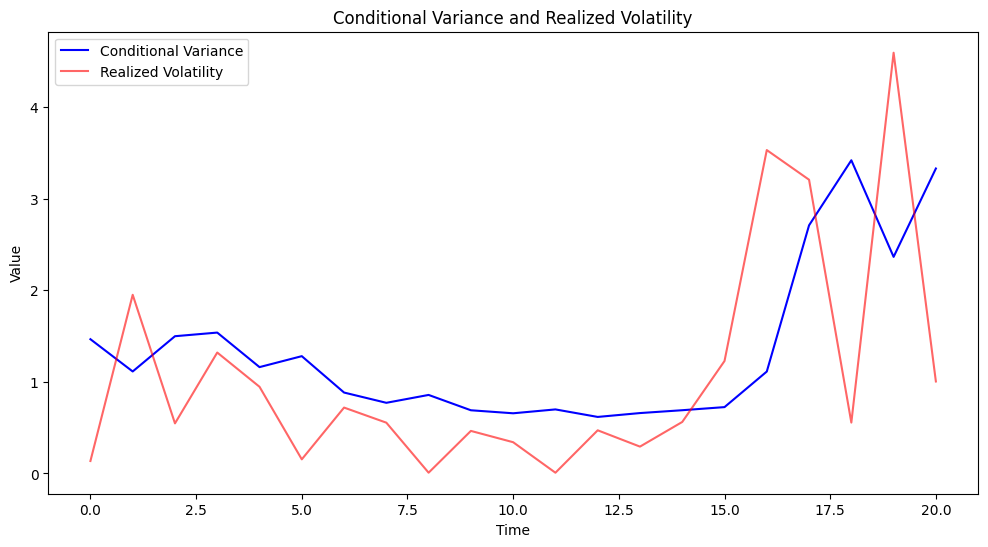

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Generate some synthetic data
np.random.seed(42)
# Generate synthetic data
returns = [0.003146575,-0.017723909,0.007254689,0.014989689,
0.011250607,0.003328635,-0.005409767,0.007332392,0.001700427,
0.006432783,-0.001627508,0.001867275,-0.002928821,0.004717681,
-0.003839112,-0.010494486,-0.033525076,-0.030286122,-0.003772137,
-0.04415351,-0.008258359]

data = np.array(returns) * 100

# Fit an ARCH model
model = arch_model( data, vol='ARCH', p=2)
model_fit = model.fit(disp='off')
conditional_volatility = model_fit.conditional_volatility

# Print the model summary
print(model_fit.summary())
print(conditional_volatility)

mu = model_fit.params['mu']
print("Mean (mu) of the trained ARCH model:", mu)

# Calculate realized volatility (absolute returns)
volatility_realised = np.abs( mu-  data)

# Plot conditional variance and realized volatility
plt.figure(figsize=(12, 6))
plt.plot(conditional_volatility[:21], label='Conditional Variance', color='blue')
plt.plot(volatility_realised[:21], label='Realized Volatility', color='red', alpha=0.6)
plt.title('Conditional Variance and Realized Volatility')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()